---
---
# NEURAL STYLE TRANSFER
---
---

# STEP 2 - Generating The Style

In [22]:
from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

In [23]:
def VGG16_AvgPool(shape):
    #we want to account for features across the entire image
    #so we get rid of the maxpool which throws away information
    #NOT: we still lose some information but as much as maxpooling
    vgg = VGG16(input_shape=shape,
                weights='imagenet',
                include_top=False)
    #Functional API
    input_ = vgg.input
    x = input_ # start from input
    # first layer is input, therefore start from 2nd index
    for layer in vgg.layers[1:]:
        if isinstance(layer, MaxPooling2D):
            #replace it with average pooling
            x = AveragePooling2D(pool_size=(2, 2), 
                                 strides=(2, 2), 
                                 padding='valid')(x)
        else:
            x = layer(x)
    # we have a graph network now. -> .input and .output can be use
    model = Model(inputs=input_, outputs=x, name="vgg16_avgpool")
    return model

def unpreprocess(img):
    """
    VGG16 preprocess_input'in tersini yapar:
    BGR -> RGB, channel mean'leri geri ekler.
    """
    img = img.copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img


def scale_img(x):
    """
    Min-max normalize [0, 1] aralığına çeker (görselleştirme için).
    """
    x = x - x.min()
    x = x / x.max()
    return x

In [24]:
def gram_matrix(img):
    #input is (H,W,C) C is # of feature maps
    # we first need to convert it into (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2,0,1)))

    #Now calculate the gram matrix
    # gram = X*X^T / N
    #the constant is not important since we'll be weighting these
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

In [25]:
def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [26]:
#lets generalize this and put into a function
def minimize(fn, epochs):
    """
    fn: x_flat -> (loss, grads_flat) dönen fonksiyon
    epochs: dış iterasyon sayısı

    Global batch_shape kullanıyor.
    """
    global batch_shape

    t0 = datetime.now()
    losses = []

    # random init (style reconstruction için uygun)
    x_vec = np.random.randn(np.prod(batch_shape)).astype("float64")

    for i in range(epochs):
        x_vec, l, _ = fmin_l_bfgs_b(
            func=fn,
            x0=x_vec,
            maxfun=20
        )
        x_vec = np.clip(x_vec, -127, 127)

        print(f"iter={i}, loss={l}")
        losses.append(l)

    print("Duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.title("Style loss during optimization")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

    newimg = x_vec.reshape(batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

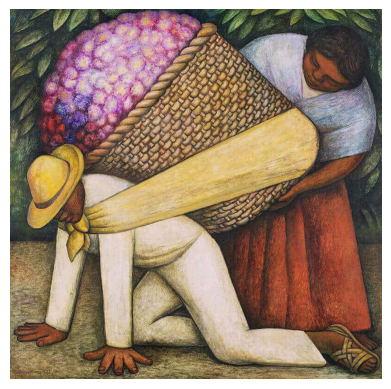

KeyboardInterrupt: 

In [28]:
if __name__ == '__main__':
    path1 = "/kaggle/input/dataset/Data/flowercarrier.jpg"
    path2 = "/kaggle/input/dataset/Data/lesdemoisellesdavignon.jpg"
    path3 = "/kaggle/input/dataset/Data/monalisa.jpg"
    path4 = "/kaggle/input/dataset/Data/starrynight.jpg"

    #load the data
    img = image.load_img(path1)
    x = image.img_to_array(img)
    #demonstrate
    plt.imshow(x.astype("uint8"))
    plt.axis("off")
    plt.show()

    #make it (1, H, W, C)
    x = np.expand_dims(x, axis=0)
    #preprocess into vgg expected format
    x = preprocess_input(x)
    
    batch_shape = x.shape    # (1, H, W, 3)
    shape = x.shape[1:]      # (H, W, 3)

    #lets take the first convolution at each block of convolutions
    #to be our target outputs
    vgg = VGG16_AvgPool(shape)

    # Her block'un ilk conv katmanını style layer olarak al
    # Örn: block1_conv1, block2_conv1, ...
    style_symbolic_outputs = [
        layer.output for layer in vgg.layers if layer.name.endswith("conv1")
    ]
    #pick the earlier layers for
    #a more 'localized' representation
    #this is opposed to the content model
    #where the later layers represent a more "global" structure
    #symbolic_conv_outputs = symbolic_conv_outputs[:2]

    # Bu layer'ların hepsini output veren model
    #make a big model that outputs multiple layers' outputs
    multi_output_model = Model(vgg.input, style_symbolic_outputs)
    # Style image için hedef feature map'leri hesapla
    style_targets = multi_output_model(x)  # liste: [ (1, H1, W1, C1), ... ]
    #calculate the total style loss
    # GradientTape ile style loss + gradient fonksiyonu
    def style_loss_and_grads(x_flat):
        x_in = tf.reshape(x_flat, batch_shape)

        with tf.GradientTape() as tape:
            tape.watch(x_in)
            outputs = multi_output_model(x_in)  # liste

            loss_value = 0.0
            for out, target in zip(outputs, style_targets):
                # out, target: (1, H, W, C)
                y = out[0]      # (H, W, C)
                t = target[0]   # (H, W, C)
                G_y = gram_matrix(y)
                G_t = gram_matrix(t)
                loss_value += tf.reduce_mean(tf.square(G_y - G_t))

        grads = tape.gradient(loss_value, x_in)

        loss_value = loss_value.numpy().astype("float64")
        grads = grads.numpy().flatten().astype("float64")
        return loss_value, grads

    # L-BFGS ile style reconstruction
    final_img = minimize(style_loss_and_grads, epochs=10)

    # Sonucu göster
    plt.imshow(scale_img(final_img))
    plt.axis("off")
    plt.show()